In [1]:
import os
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import utils

In [3]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/MNIST'
(X_train, y_train), (X_val, y_val), (X_test, y_test) = utils.load_mnist_dataset(dataset_path)

In [4]:
# Suvival MNIST generator returns event_times, censor_times, durations, event_indicators
train_event_times, _, train_durations, train_labels = utils.generate_survival_mnist(y_train, random_state=42)
_, _, val_durations, val_labels = utils.generate_survival_mnist(y_val, random_state=42)
_, _, test_durations, test_labels = utils.generate_survival_mnist(y_test, random_state=42)

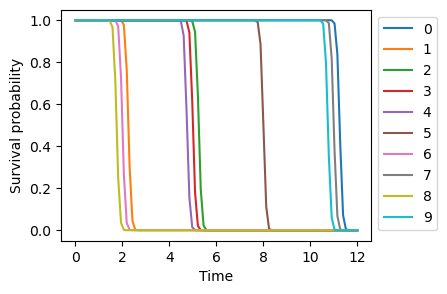

In [5]:
def percent(y):
    return np.sum(y)/len(y)

ncols, nrows = 1, 1
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows))
for label in range(10):
    ax.plot(np.linspace(0, 12, num=100), [percent(train_event_times[y_train==label]>i) for i in np.linspace(0, 12, num=100)], label=f'{label}')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time')
ax.set_ylabel('Survival probability')
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
#legend.set_in_layout(False)
#fig.tight_layout()
plt.show()

In [6]:
print('Censoring Rates')
for label in [8, 6, 1, 4, 3, 2, 5, 9, 7, 0]:
    print(f'Digit {label}: {100*(1-percent(train_labels[y_train==label])):.2f}%')

Censoring Rates
Digit 8: 3.14%
Digit 6: 5.78%
Digit 1: 8.10%
Digit 4: 34.31%
Digit 3: 36.97%
Digit 2: 39.49%
Digit 5: 66.96%
Digit 9: 95.79%
Digit 7: 98.72%
Digit 0: 99.92%


In [7]:
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

kmf = KaplanMeierFitter()
kmf.fit(durations=train_durations, event_observed=train_labels)
train_CI = concordance_index(train_durations, -kmf.survival_function_at_times(train_durations).values, train_labels)
val_CI = concordance_index(val_durations, -kmf.survival_function_at_times(val_durations).values, val_labels)
test_CI = concordance_index(test_durations, -kmf.survival_function_at_times(test_durations).values, test_labels)

print("Train CI:", train_CI)
print("Val CI:", val_CI)
print("Test CI:", test_CI)

Train CI: 0.9999839203280635
Val CI: 0.9999635905282755
Test CI: 0.9999469129571119


In [28]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/time-to-event/experiments/MSEUncensored'
loss_func = 'MSEUncensored'
lrs = [0.1, 0.01, 0.001, 0.0001]
hidden_dimensions = [1, 2, 4, 8, 16]
random_states = [1001, 2001, 3001]
weight_decays = [0.1, 0.01, 0.001, 0.0001, 0.0]
count = -1
for lr, hidden_dimension, random_state, weight_decay in itertools.product(lrs, hidden_dimensions, random_states, weight_decays):
    count += 1
    model_name = f'lr={lr}_hidden_dimension={hidden_dimension}_random_state={random_state}_weight_decay={weight_decay}'
    print(f'    "python ../src/main.py --experiments_path=\'{experiments_path}\' --loss_func=\'{loss_func}\' --lr={lr} --hidden_dimension={hidden_dimension} --model_name=\'{model_name}\' --random_state={random_state} --weight_decay={weight_decay}"')
print(count)

    "python ../src/main.py --experiments_path='/cluster/tufts/hugheslab/eharve06/time-to-event/experiments/MSEUncensored' --loss_func='MSEUncensored' --lr=0.1 --hidden_dimension=1 --model_name='lr=0.1_hidden_dimension=1_random_state=1001_weight_decay=0.1' --random_state=1001 --weight_decay=0.1"
    "python ../src/main.py --experiments_path='/cluster/tufts/hugheslab/eharve06/time-to-event/experiments/MSEUncensored' --loss_func='MSEUncensored' --lr=0.1 --hidden_dimension=1 --model_name='lr=0.1_hidden_dimension=1_random_state=1001_weight_decay=0.01' --random_state=1001 --weight_decay=0.01"
    "python ../src/main.py --experiments_path='/cluster/tufts/hugheslab/eharve06/time-to-event/experiments/MSEUncensored' --loss_func='MSEUncensored' --lr=0.1 --hidden_dimension=1 --model_name='lr=0.1_hidden_dimension=1_random_state=1001_weight_decay=0.001' --random_state=1001 --weight_decay=0.001"
    "python ../src/main.py --experiments_path='/cluster/tufts/hugheslab/eharve06/time-to-event/experiments

In [9]:
def split_filename(filename):
    pattern = r'[-+]?\d*\.\d+|\d+'
    matches = list(map(float, re.findall(pattern, filename)))
    return matches

In [22]:
best_model = {'df': None, 'path': None, 'val_CI': 0.0}
experiments_path = '/cluster/tufts/hugheslab/eharve06/time-to-event/experiments/CustomLoss'
files = os.listdir(experiments_path)
for file in files:
    if file.endswith('.csv'):
        matches = split_filename(file)
        df = pd.read_csv(f'{experiments_path}/{file}')
        moving_average = df.val_CI.rolling(window=30).mean().fillna(0.0).values        
        if moving_average[-1] > best_model['val_CI']:
            best_model['df'] = df.copy()
            best_model['path'] = f'{experiments_path}/{file}'
            best_model['val_CI'] = moving_average[-1]

/cluster/tufts/hugheslab/eharve06/time-to-event/experiments/CustomLoss/lr=0.001_hidden_dimension=16_random_state=1001_weight_decay=0.0.csv
train_CI: 0.9659
val_CI: 0.9580
test_CI: 0.9575


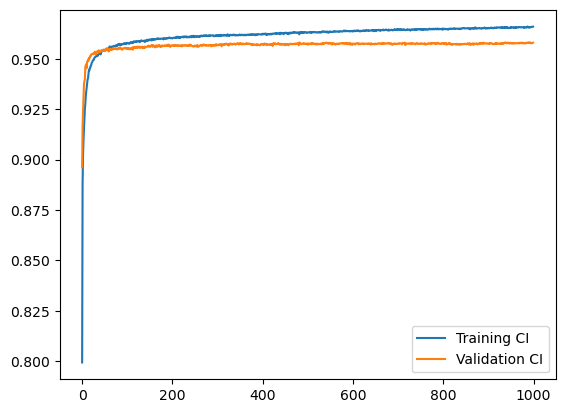

In [23]:
print(best_model['path'])
print(f"train_CI: {best_model['df'].train_CI.values[-1]:.4f}")
print(f"val_CI: {best_model['df'].val_CI.values[-1]:.4f}")
print(f"test_CI: {best_model['df'].test_CI.values[-1]:.4f}")
plt.plot(best_model['df'].train_CI, label='Training CI')
plt.plot(best_model['df'].val_CI, label='Validation CI')
plt.legend()
plt.show()